In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from scipy import signal as scisig

In [2]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
config = tf.ConfigProto(gpu_options=gpu_options)

In [ ]:
sess = tf.InteractiveSession() # don't use in general

In [3]:
sample_rate = 16000 # Hz
X = tf.placeholder(tf.float32, shape=[None], name='signal')

nunits = 32
filter_time = 0.05 # seconds
lfilter = int(filter_time*sample_rate) # number of samples in a filter
# initialize filters...they get set to gammachirps later, though
filters = tf.Variable(tf.random_normal([nunits, lfilter]), name='filters')

Xnow = tf.placeholder(tf.float32, shape=[lfilter], name='signal_segment')
filX = tf.squeeze(tf.matmul(filters, tf.expand_dims(Xnow,dim=1)))
candidate = tf.cast(tf.argmax(tf.abs(filX), axis=0), tf.int32)
cand_contrib = tf.scalar_mul(filX[candidate],filters[candidate])

# define op for learning (which I haven't done yet), not sure the reconstruction is right
final_coeffs = tf.placeholder(tf.float32, shape=[nunits, None], name='final_coefficients')
rev_filters = tf.reverse(filters, dims=[False, True])
Xhat = tf.nn.convolution(tf.expand_dims(final_coeffs, dim=0), 
                         tf.transpose(tf.expand_dims(rev_filters, dim=2),[1,0,2]),
                         padding="VALID", data_format="NCW") # needs attention
loss = tf.reduce_mean(tf.square(X - tf.squeeze(Xhat)), name='loss')
learn_rate = tf.Variable(0.01, trainable=False)
#learner = tf.train.GradientDescentOptimizer(learn_rate)
learner = tf.train.AdamOptimizer(learning_rate=learn_rate)
learn_step = tf.Variable(0,name='learn_step', trainable=False)
learn_op = learner.minimize(loss, global_step=learn_step, var_list=[filters])
normalize = filters.assign(tf.nn.l2_normalize(filters, dim=1, epsilon=1e-30))

In [4]:
def infer(signal, lam):
    resid = np.concatenate([signal, np.zeros(lfilter-1)], axis=0)
    recon = np.zeros_like(resid)
    lspikes = resid.shape[0]
    spikes = np.zeros([nunits, lspikes])
    for tt in range(lfilter, lspikes+1):
        filout, cand, contrib = sess.run((filX, candidate, cand_contrib), feed_dict = {Xnow : resid[tt-lfilter:tt]})
        sp = filout[cand]
        if np.abs(sp) > lam:
            resid[tt-lfilter:tt] -= contrib
            recon[tt-lfilter:tt] += contrib
            spikes[cand, tt-1] = sp
    return spikes, recon
    #return np.concatenate([np.zeros([nunits, lfilter-1]),spikes], axis=1)
    
def np_infer(signal, Phi, lam):
    resid = np.concatenate([signal, np.zeros(lfilter-1)], axis=0)
    recon = np.zeros_like(resid)
    lspikes = resid.shape[0]
    spikes = np.zeros([nunits, lspikes])
    for tt in range(lfilter, lspikes+1):
        filX = Phi @ resid[tt-lfilter:tt]
        cand = np.argmax(np.abs(filX))
        sp = filX[cand]
        if np.abs(sp) > lam:
            contrib = filX[cand]*Phi[cand]
            resid[tt-lfilter:tt] -= contrib
            recon[tt-lfilter:tt] += contrib
            spikes[cand, tt-1] = sp
    return spikes, recon

In [5]:
# dynamic compressive gammachirp
def dcGC(t,f):
    """Dynamic compressive gammachirp filter as defined by Irino,
    with parameters from Park as used in Charles, Kressner, & Rozell.
    The log term is regularized to log(t + 0.00001).
    t : time in seconds, greater than 0
    f : characteristic frequency in Hz
    One but not both arguments may be numpy arrays.
    """
    ERB = 0.1039*f + 24.7
    return t**3 * np.exp(-2*np.pi*1.14*ERB*t) * np.cos(2*np.pi*f*t + 0.979*np.log(t+0.000001))

gammachirps = np.zeros([nunits, lfilter])
freqs = np.logspace(np.log10(100), np.log10(6000), nunits)
times = np.linspace(0,filter_time,lfilter)
for ii in range(nunits):
    gammachirps[ii] = dcGC(times, freqs[ii])

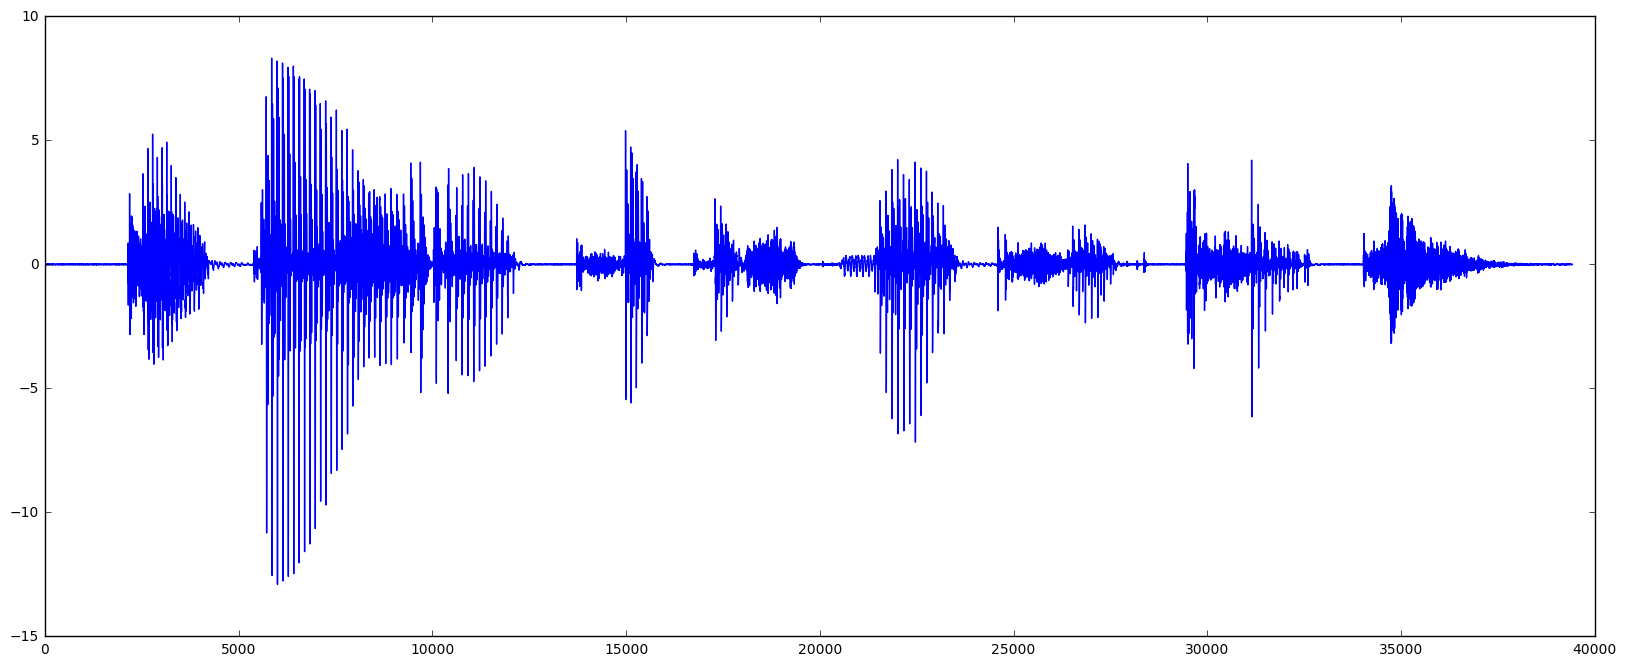

In [35]:
folder = '../Data/TIMIT/'
files = os.listdir(folder)
file = None
for ff in files:
    if ff.endswith('.wav'):
        file = os.path.join(folder,ff)
        break
rate, signal = wavfile.read(file)
# bandpass
signal = signal/signal.std()

# adapted from scipy cookbook
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scisig.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scisig.lfilter(b, a, data)
    return y

lowcut = 100
highcut = 6000
signal = butter_bandpass_filter(signal, lowcut, highcut, sample_rate, order=5)

plt.figure(figsize=(20,8))
plt.plot(signal)

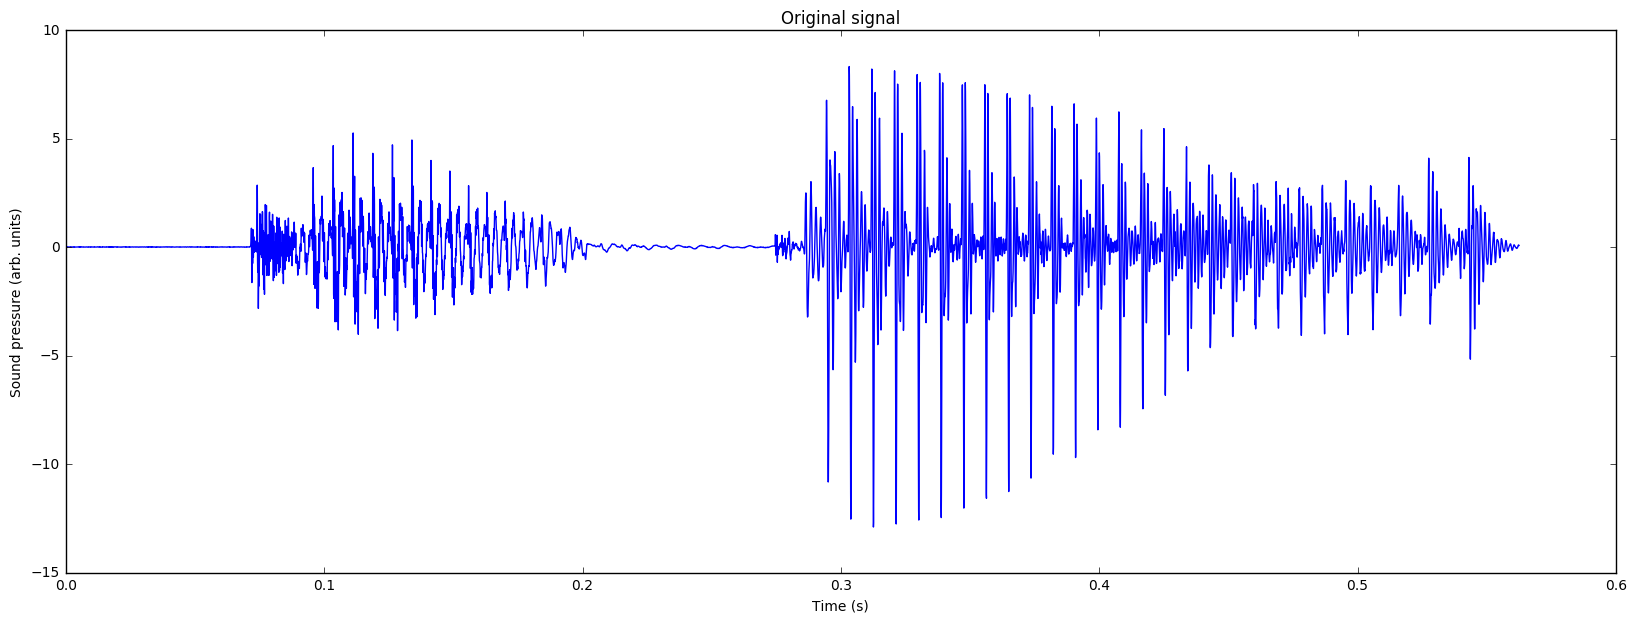

In [54]:
start = 1000
end = 10000
times = np.linspace(0, (end - start)/sample_rate,end-start)
plt.figure(figsize=(20,7))
plt.plot(times, signal[start:end])
plt.xlabel('Time (s)')
plt.ylabel('Sound pressure (arb. units)')
plt.title("Original signal")

In [9]:
spikes, recon = infer(signal[start:end], 0.1)

In [52]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(filters.assign(tf.constant(gammachirps.reshape([nunits,lfilter]), dtype=tf.float32)))
    sess.run(normalize)
    Phi = sess.run(filters)
np_spikes, np_recon = np_infer(signal[start:end],Phi, 0.1)

In [6]:
def plotSpikeGram( spikes, markerSize = .0001 ):
    """adapted from https://github.com/craffel/spikegram-coding/blob/master/plotSpikeGram.py"""
    nkernels = spikes.shape[0]
    indices = np.transpose(np.nonzero(spikes))
    print(indices.shape)
    scalesKernelsAndOffsets = [(spikes[idx[0],idx[1]], idx[0], idx[1]) for idx in indices]
    
    for scale, kernel, offset in scalesKernelsAndOffsets:
        # Put a dot at each spike location.  Kernels on y axis.  Dot size corresponds to scale
        plt.plot( offset/sample_rate, nkernels-kernel, 'k.', markersize=markerSize*np.abs( scale ) )
    plt.title( "Spikegram" )
    plt.xlabel( "Time (s)" )
    plt.ylabel( "Kernel" )
    plt.axis( [0.0, spikes.shape[1]/sample_rate, 0.0, nkernels] )
    plt.show()

(6978, 2)


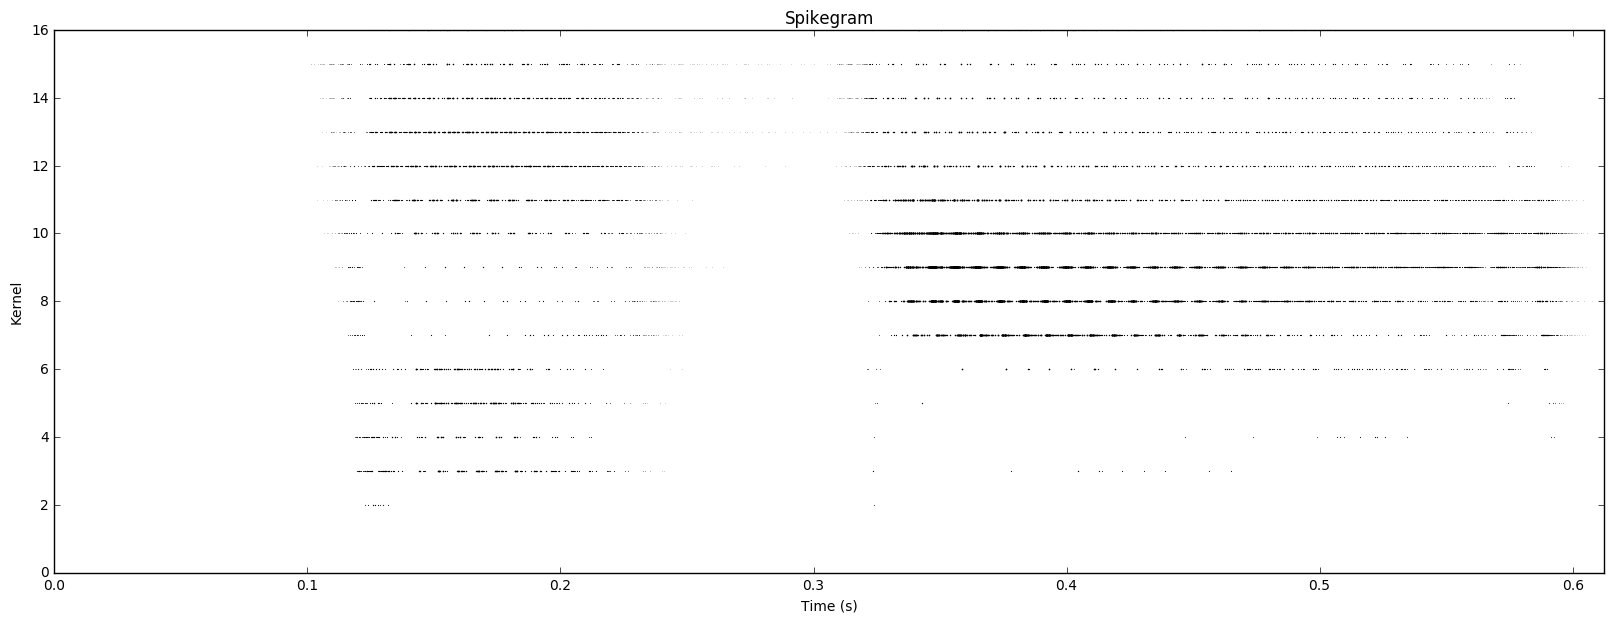

In [41]:
plt.figure(figsize=(20,7))
plotSpikeGram(np_spikes, 1)

(7133, 2)


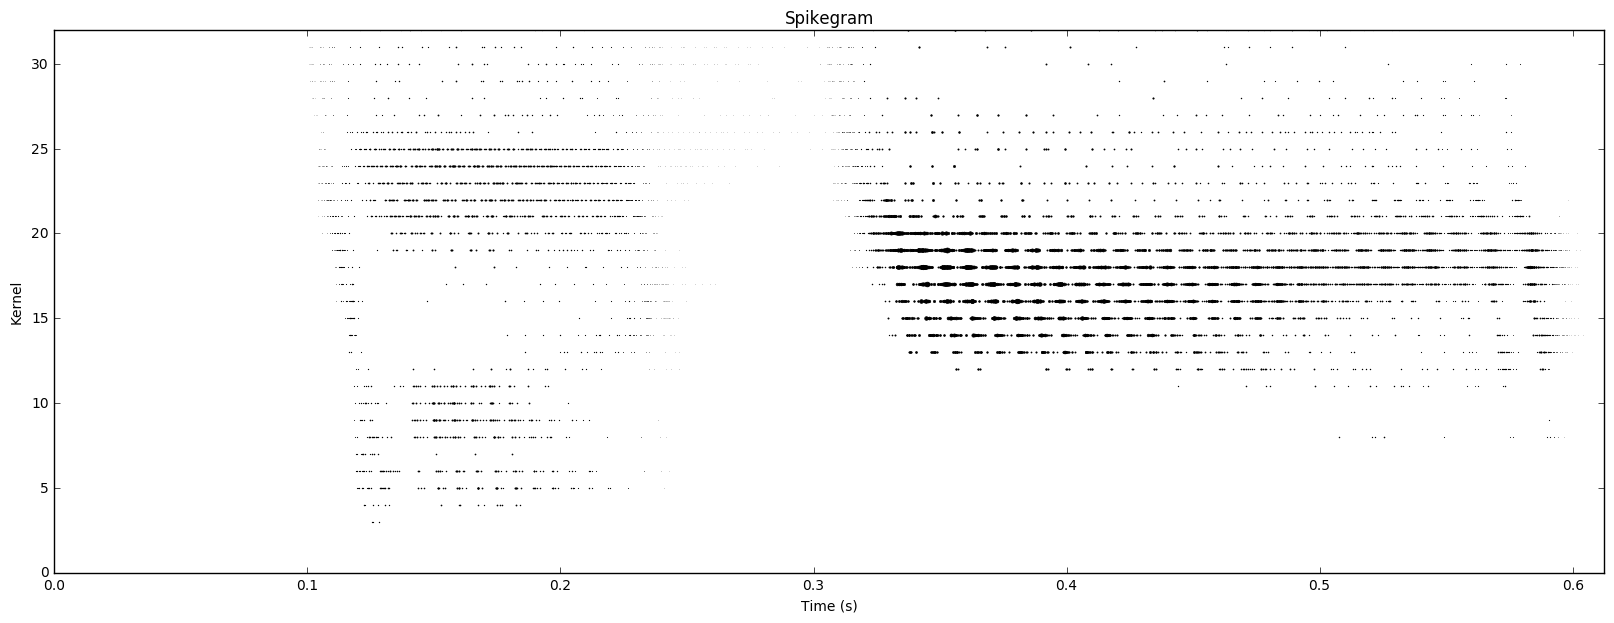

In [14]:
plt.figure(figsize=(20,7))
plotSpikeGram(np_spikes,1)

In [42]:
feed_dict = {X : signal[start:end], final_coeffs : np_spikes}
#sess.run((loss,learn_op), feed_dict = feed_dict)

In [17]:
recon2 = sess.run([Xhat], feed_dict=feed_dict)[0][0,0]

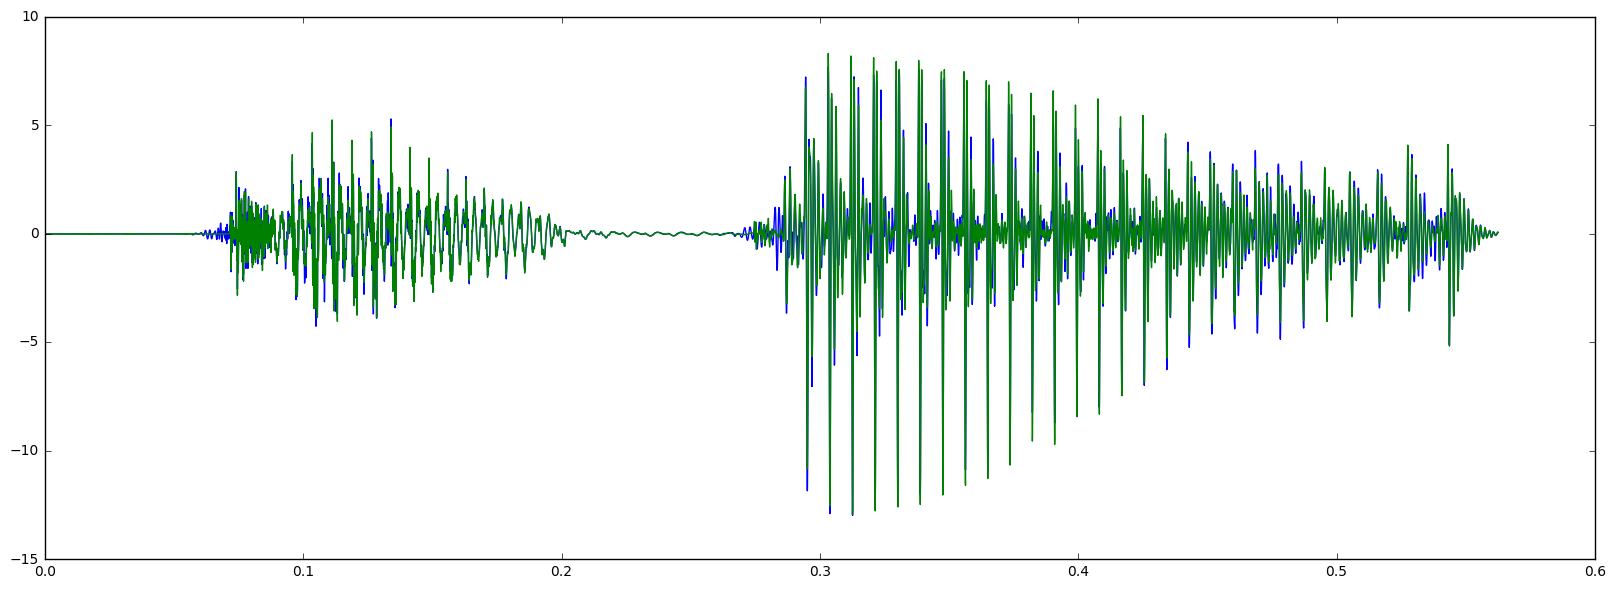

In [16]:
plt.figure(figsize=(20,7))
plt.plot(times, recon2[:end-start], 'b', times, signal[start:end], 'g')

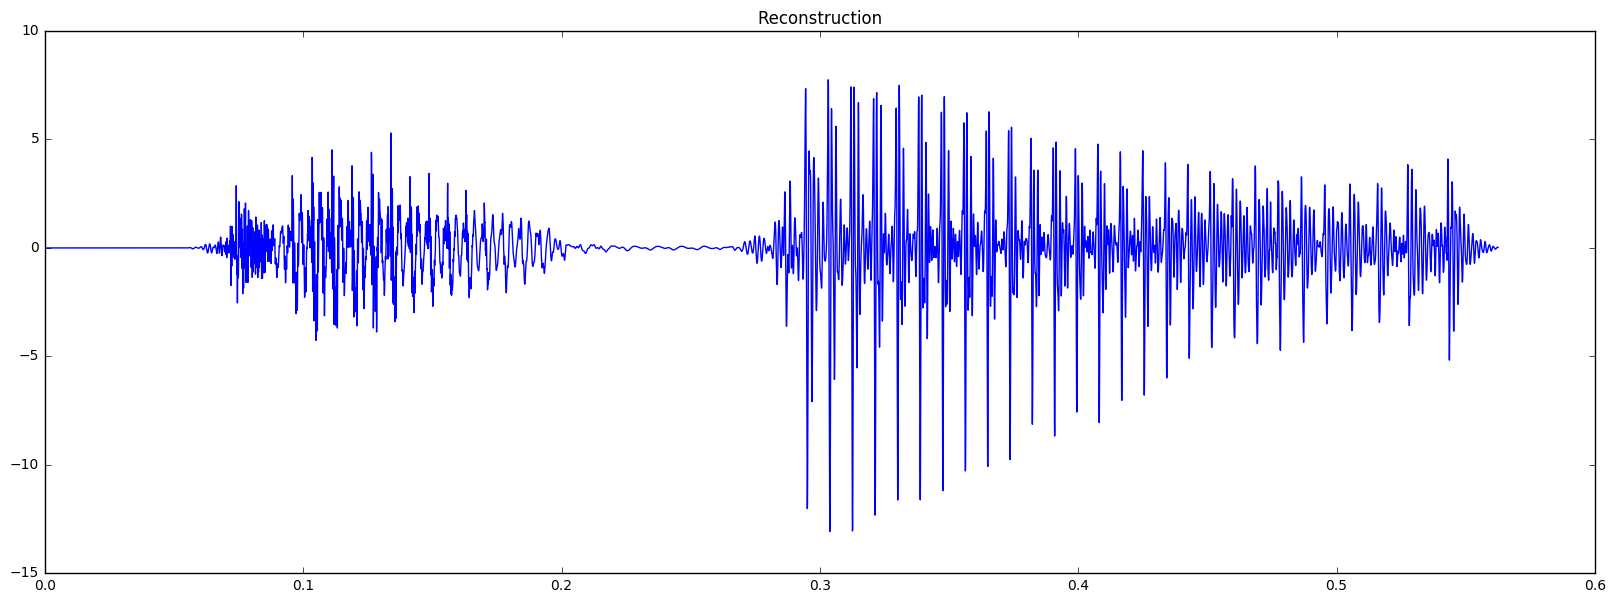

In [55]:
plt.figure(figsize=(20,7))
plt.plot(times, np_recon[:end-start], 'b')
plt.title('Reconstruction')

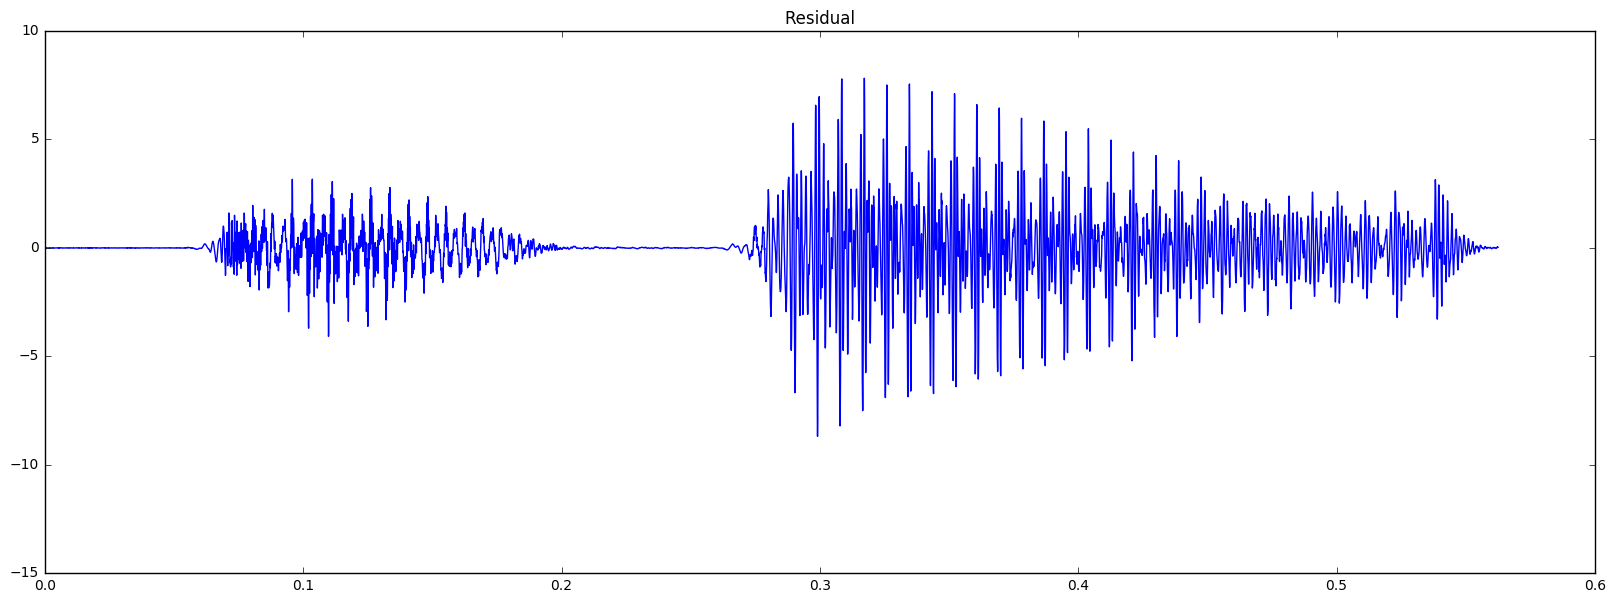

In [45]:
plt.figure(figsize=(20,7))
plt.plot(times, signal[start:end] - np_recon[:end-start] , 'b')
plt.ylim((-15, 10))
plt.title('Residual')

In [7]:
def snr(signal, recon):
    """Returns signal-noise ratio in dB."""
    ratio = np.var(signal)/np.var(signal-recon)
    return 10*np.log10(ratio)

In [48]:
snr(signal[start:end], np_recon[:end-start])

1.3221367037480771

In [18]:
snr(signal[start:end], recon[:end-start])

11.559853500450012

In [19]:
snr(signal[start:end], recon2) 

11.55985362006254

In [20]:
nspikes = np.count_nonzero(np_spikes)

In [22]:
nspikes/(end-start)

0.7925555555555556

In [21]:
nspikes/(end-start)/nunits

0.02476736111111111

# Learning!

## Load data

In [8]:
# adapted from scipy cookbook
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scisig.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scisig.lfilter(b, a, data)
    return y

lowcut = 100
highcut = 6000

min_length = 10000

folder = '../Data/TIMIT/'
files = os.listdir(folder)
file = None
data = []
for ff in files:
    if ff.endswith('.wav'):
        file = os.path.join(folder,ff)
        rate, signal = wavfile.read(file)
        if signal.shape[0] > min_length:
            # bandpass
            signal = signal/signal.std()
            signal = butter_bandpass_filter(signal, lowcut, highcut, sample_rate, order=5)
            data.append(signal)
ndata = len(data)
print(ndata)
            
def rand_stim(min_rms = 0.7):
    """Get one random segment of length lsignal from one random signal."""
    rms = 0
    while rms < min_rms:
        which = np.random.randint(low=0, high=ndata)
        whole = data[which]
        #length = whole.shape[0]
        #start = np.random.randint(low=0, high=length-lsignal)
        #segment =  whole[start:start+lsignal]
        segment = whole
        rms = segment.std()
        segment /= np.max(segment) # as in Smith/Lewicki
    return segment

6292


In [9]:
def learn_step(sess, lam = 0.8):
    signal = rand_stim()
    lsignal = signal.shape[0]
    spikes, recon = np_infer(signal, sess.run(filters), lam)
    feed_dict = {X : signal, final_coeffs : spikes}
    error, _ = sess.run((loss, learn_op), feed_dict = feed_dict)
    sess.run(normalize)
    nspikes = np.count_nonzero(spikes)
    act_fraction = nspikes/lsignal
    return error, act_fraction

# Training from noise

In [ ]:
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    #sess.run(filters.assign(tf.constant(gammachirps.reshape([nunits,lfilter]), dtype=tf.float32)))
    sess.run(normalize)
    initPhi = sess.run(filters)
    threshold = 1.5
    #sess.run(learn_rate.assign(1.0))
    ntrials = 50000
    error_history = np.zeros(ntrials)
    acts_history = np.zeros(ntrials)
    for ii in range(ntrials):
        error, act_frac = learn_step(sess, lam=threshold)
        Phi = sess.run(filters)
        error_history[ii] = error
        acts_history[ii] = act_frac
        if ii%50 == 0:
            print(ii)
    
plt.plot(error_history, 'b.', acts_history, 'r.')

0


In [26]:
# for continuing
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    #sess.run(filters.assign(tf.constant(gammachirps.reshape([nunits,lfilter]), dtype=tf.float32)))
    sess.run(normalize)
    sess.run(filters.assign(Phi))
    threshold = 1.5
    #sess.run(learn_rate.assign(1.0))
    nexttime = 0
    while error_history[nexttime] != 0:
        nexttime += 1
    for ii in range(nexttime, ntrials):
        error, act_frac = learn_step(sess, lam=threshold)
        Phi = sess.run(filters)
        error_history[ii] = error
        acts_history[ii] = act_frac
        if ii%50 == 0:
            print(ii)
    
plt.plot(error_history, 'b.', acts_history, 'r.')

KeyboardInterrupt: 

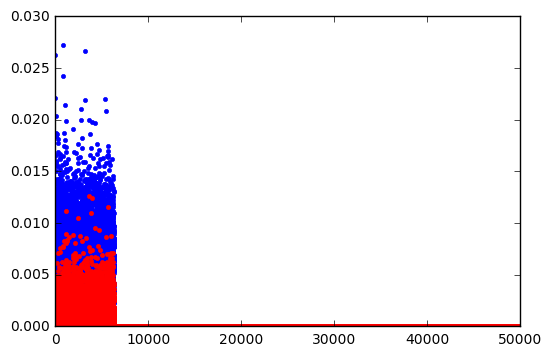

In [11]:
plt.plot(error_history, 'b.', acts_history, 'r.')

In [19]:
np.save('fromnoise.npy', Phi)

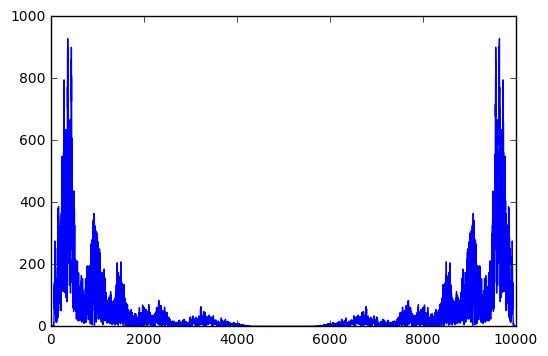

In [37]:
plt.plot(np.abs(np.fft.fft(rand_stim())))

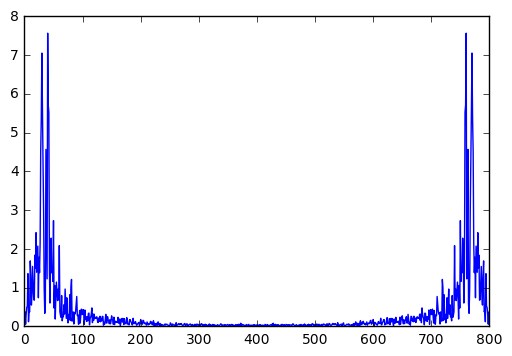

In [22]:
plt.plot(np.abs(np.fft.fft(Phi[0])))

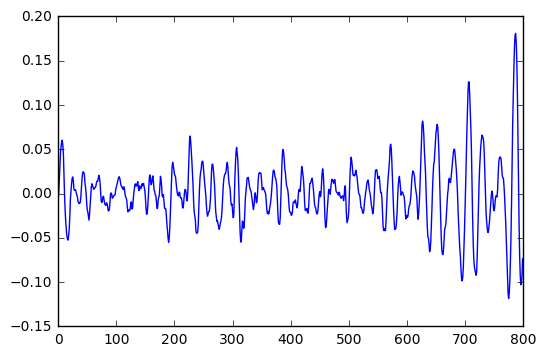

In [25]:
plt.plot(Phi[0])

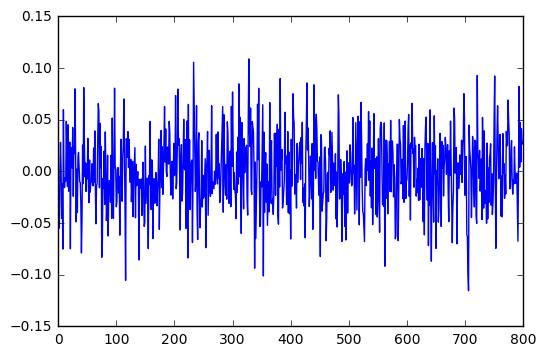

In [19]:
plt.plot(initPhi[0])

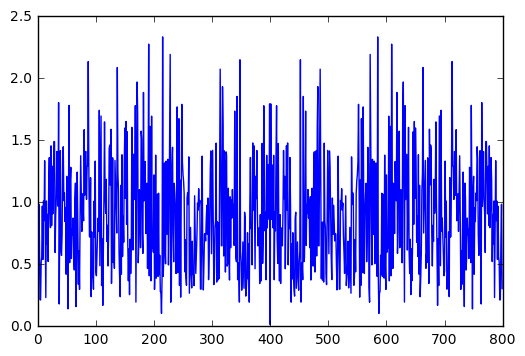

In [15]:
plt.plot(np.abs(np.fft.fft(initPhi[5])))

# Training from gammachirps

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950


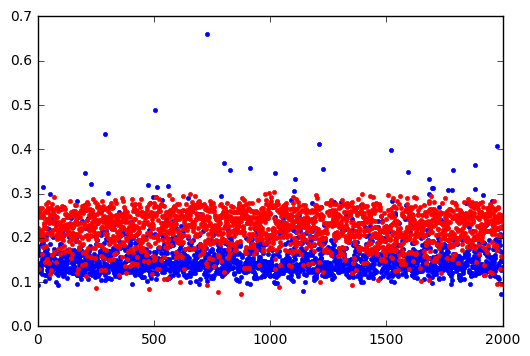

In [16]:
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(filters.assign(tf.constant(gammachirps.reshape([nunits,lfilter]), dtype=tf.float32)))
    sess.run(normalize)
    ginitPhi = sess.run(filters)
    threshold = 1.5
    sess.run(learn_rate.assign(1.0))
    ntrials = 2000
    error_history = np.zeros(ntrials)
    acts_history = np.zeros(ntrials)
    for ii in range(ntrials):
        error, act_frac = learn_step(lam=threshold)
        error_history[ii] = error
        acts_history[ii] = act_frac
        if ii%50 == 0:
            print(ii)
    gPhi = sess.run(filters)
plt.plot(error_history, 'b.', acts_history, 'r.')

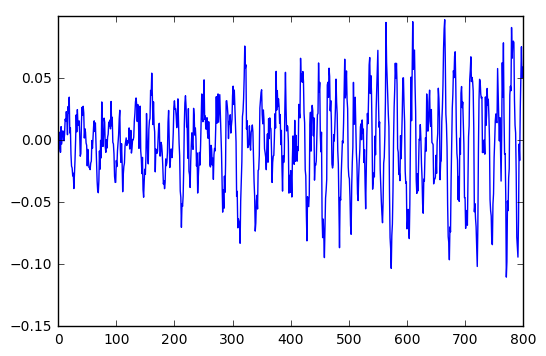

In [19]:
plt.plot(gPhi[0])

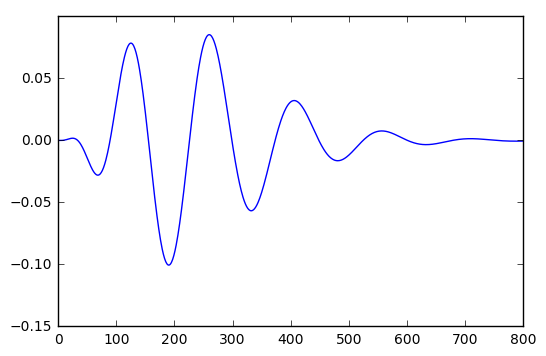

In [20]:
plt.plot(ginitPhi[0])

In [25]:
np_spikes, np_recon = np_infer(signal[start:end], Phi, 0.1)

In [28]:
snr(signal[start:end], np_recon[:end-start])

9.8474406089310804

In [31]:
np_spikes, np_recon = np_infer(signal[start:end], ginitPhi, 0.1)
snr(signal[start:end], np_recon[:end-start])

11.559853787822977

In [15]:
plt.plot()

array([ 0.00760209,  0.01454572,  0.00570733, ...,  0.        ,
        0.        ,  0.        ])